# The Agent Loop: Building Production Agents with LangChain 1.0

In this notebook, we'll explore the foundational concepts of AI agents and learn how to build production-grade agents using LangChain's new `create_agent` abstraction with middleware support.

**Learning Objectives:**
- Understand what an "agent" is and how the agent loop works
- Learn the core constructs of LangChain (Runnables, LCEL)
- Master the `create_agent` function and middleware system
- Build an agentic RAG application using Qdrant

## Table of Contents:

- **Breakout Room #1:** Introduction to LangChain, LangSmith, and `create_agent`
  - Task 1: Dependencies
  - Task 2: Environment Variables
  - Task 3: LangChain Core Concepts (Runnables & LCEL)
  - Task 4: Understanding the Agent Loop
  - Task 5: Building Your First Agent with `create_agent()`
  - Question #1 & Question #2
  - Activity #1: Create a Custom Tool

- **Breakout Room #2:** Middleware - Agentic RAG with Qdrant
  - Task 6: Loading & Chunking Documents
  - Task 7: Setting up Qdrant Vector Database
  - Task 8: Creating a RAG Tool
  - Task 9: Introduction to Middleware
  - Task 10: Building Agentic RAG with Middleware
  - Question #3 & Question #4
  - Activity #2: Enhance the Agent

---
# 🤝 Breakout Room #1
## Introduction to LangChain, LangSmith, and `create_agent`

## Task 1: Dependencies

First, let's ensure we have all the required packages installed. We'll be using:

- **LangChain 1.0+**: The core framework with the new `create_agent` API
- **LangChain-OpenAI**: OpenAI model integrations
- **LangSmith**: Observability and tracing
- **Qdrant**: Vector database for RAG
- **tiktoken**: Token counting for text splitting

In [1]:
# Run this cell to install dependencies (if not using uv sync)
# !pip install langchain>=1.0.0 langchain-openai langsmith langgraph qdrant-client langchain-qdrant tiktoken nest-asyncio

In [2]:
# Core imports we'll use throughout the notebook
import os
import getpass
from uuid import uuid4

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

## Task 2: Environment Variables

We need to set up our API keys for:
1. **OpenAI** - For the GPT-5 model
2. **LangSmith** - For tracing and observability (optional but recommended)

In [3]:
# Set OpenAI API Key
# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")
import os
import openai
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key
langchain_key = os.getenv("LANGCHAIN_API_KEY")


In [50]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

#os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_PROJECT"] = "pr-ample-bean-55"
os.environ["LANGSMITH_PROJECT"] = "pr-ample-bean-55"
os.environ["LANGCHAIN_API_KEY"] = langchain_key


os.environ["LANGCHAIN_TRACING_V2"] = "false"
# if not os.environ["LANGCHAIN_API_KEY"]:
#     os.environ["LANGCHAIN_TRACING_V2"] = "false"
#     print("LangSmith tracing disabled")
# else:
#     print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")



In [51]:

# # lets test langsmith configuration
from dotenv import load_dotenv
import os

load_dotenv()

issues = []

if os.getenv("LANGCHAIN_TRACING_V2") != "true":
    issues.append("❌ LANGCHAIN_TRACING_V2 is not 'true'")
else:
    print("✅ LANGCHAIN_TRACING_V2 = true")

if not os.getenv("LANGCHAIN_API_KEY"):
    issues.append("❌ LANGCHAIN_API_KEY is not set")
else:
    print("✅ LANGCHAIN_API_KEY is set")

project = os.getenv("LANGCHAIN_PROJECT")
if not project:
    issues.append("⚠️ LANGCHAIN_PROJECT not set (will use 'default')")
else:
    print(f"✅ LANGCHAIN_PROJECT = {project}")

if issues:
    print("\nIssues found:")
    for issue in issues:
        print(f"  {issue}")
else:
    print("\n✅ All environment variables look good!")


from langsmith import Client

client = Client()
try:
    projects = list(client.list_projects(limit=3))
    print("✅ LangSmith connection works!")
    print("Your projects:", [p.name for p in projects])
except Exception as e:
    print(f"❌ LangSmith connection failed: {e}")


from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
response = llm.invoke("Say hello in French")
print(response.content)

from langchain.agents import create_agent
from langsmith import traceable

@traceable
def format_prompt(subject):
    "TEST LANGSMITH TRACING!!!"+subject
    print("TEST LANGSMITH TRACING!!!"+subject)
test_langsmith = format_prompt("LangSmith")

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"


agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[get_weather],
    system_prompt="You are a helpful assistant",
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "What is the weather in San Francisco?"}]}
)

✅ LANGCHAIN_API_KEY is set
✅ LANGCHAIN_PROJECT = pr-ample-bean-55

Issues found:
  ❌ LANGCHAIN_TRACING_V2 is not 'true'
✅ LangSmith connection works!
Your projects: ['pr-ample-bean-55', 'AIE9 - The Agent Loop - f45471ab', 'AIE9 - The Agent Loop - f84c617b']
Hello in French is "Bonjour."
TEST LANGSMITH TRACING!!!LangSmith


{'messages': [HumanMessage(content='What is the weather in San Francisco?', additional_kwargs={}, response_metadata={}, id='5bf7dcef-2cf1-4632-a8de-a7b6778527e8'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 142, 'total_tokens': 230, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D1aF9p4pZRMnUdpbmdDiwzmLMzhfF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bf0b6-0393-7bc2-a535-2b00be78320c-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'San Francisco'}, 'id': 'call_2RbupmuUs0uDQa2VrUjEbVqj', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 142,

## Task 3: LangChain Core Concepts

Before diving into agents, let's understand the fundamental building blocks of LangChain.

### What is a Runnable?

A **Runnable** is the core abstraction in LangChain - think of it as a standardized component that:
- Takes an input
- Performs some operation
- Returns an output

Every component in LangChain (models, prompts, retrievers, parsers) is a Runnable, which means they all share the same interface:

```python
result = runnable.invoke(input)           # Single input
results = runnable.batch([input1, input2]) # Multiple inputs
for chunk in runnable.stream(input):       # Streaming
    print(chunk)
```

### What is LCEL (LangChain Expression Language)?

**LCEL** allows you to chain Runnables together using the `|` (pipe) operator:

```python
chain = prompt | model | output_parser
result = chain.invoke({"query": "Hello!"})
```

This is similar to Unix pipes - the output of one component becomes the input to the next.

In [52]:
# Let's see LCEL in action with a simple example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

model = ChatOpenAI(model="gpt-5", temperature=0.7)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | model | output_parser

In [53]:
# Invoke the chain
response = pirate_chain.invoke({"question": "What is the capital of France?"})
print(response)

Arrr, the capital o’ France be Paris, matey!


## Task 4: Understanding the Agent Loop

### What is an Agent?

An **agent** is a system that uses an LLM to decide what actions to take. Unlike a simple chain that follows a fixed sequence, an agent can:

1. **Reason** about what to do next
2. **Take actions** by calling tools
3. **Observe** the results
4. **Iterate** until the task is complete

### The Agent Loop

The core of every agent is the **agent loop**:

```
                          AGENT LOOP                         
                                                             
      +----------+     +----------+     +----------+         
      |  Model   | --> |   Tool   | --> |  Model   | --> ... 
      |   Call   |     |   Call   |     |   Call   |         
      +----------+     +----------+     +----------+         
           |                                  |              
           v                                  v              
      "Use search"                   "Here's the answer"     
```

1. **Model Call**: The LLM receives the current state and decides whether to:
   - Call a tool (continue the loop)
   - Return a final answer (exit the loop)

2. **Tool Call**: If the model decides to use a tool, the tool is executed and its output is added to the conversation

3. **Repeat**: The loop continues until the model decides it has enough information to answer

### Why `create_agent`?

LangChain 1.0 introduced `create_agent` as the new standard way to build agents. It provides:

- **Simplified API**: One function to create production-ready agents
- **Middleware Support**: Hook into any point in the agent loop
- **Built on LangGraph**: Uses the battle-tested LangGraph runtime under the hood

## Task 5: Building Your First Agent with `create_agent()`

Let's build a simple agent that can perform calculations and tell the time.

### Step 1: Define Tools

Tools are functions that the agent can call. We use the `@tool` decorator to create them.

In [54]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


### Step 2: Create the Agent

Now we use `create_agent` to build our agent. The function takes:
- `model`: The LLM to use (can be a string like `"gpt-5"` or a model instance)
- `tools`: List of tools the agent can use
- `prompt`: Optional system prompt to customize behavior

In [55]:
from langchain.agents import create_agent

# Create our first agent
simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)

print("Agent created successfully!")
print(f"Type: {type(simple_agent)}")

Agent created successfully!
Type: <class 'langgraph.graph.state.CompiledStateGraph'>


### Step 3: Run the Agent

The agent is a Runnable, so we can invoke it like any other LangChain component.

In [56]:
# Test the agent with a simple calculation
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 25 * 48?"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
25 × 48 = 1200.

Reasoning:
- Mental math: 25 × (50 − 2) = 1250 − 50 = 1200.
- Confirmed with a calculator.


In [57]:
# Test with a multi-step question that requires multiple tool calls
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What time is it, and what is 100 divided by the current hour?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
- Current time (from my system clock): 10:54:22
- Reasoning: The current hour is 10, so 100 ÷ 10 = 10.0
- Result: 10.0


In [58]:
# Let's see the full conversation to understand the agent loop
print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(f"\n[{role.upper()}]")
    print(content[:500] if len(str(content)) > 500 else content)

Full Agent Conversation:

[HUMAN]
What time is it, and what is 100 divided by the current hour?

[AI]


[TOOL]
The current date and time is: 2026-01-24 10:54:22

[AI]


[TOOL]
The result of 100 / 10 is 10.0

[AI]
- Current time (from my system clock): 10:54:22
- Reasoning: The current hour is 10, so 100 ÷ 10 = 10.0
- Result: 10.0


### Streaming Agent Responses

For better UX, we can stream the agent's responses as they're generated.

In [59]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Calculate 15% of 250"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]

[Node: tools]
The result of 250 * 0.15 is 37.5

[Node: model]
To find 15% of 250, multiply 250 by 0.15.

250 × 0.15 = 37.5

Answer: 37.5


---
## ❓ Question #1:

In the agent loop, what determines whether the agent continues to call tools or returns a final answer to the user? How does `create_agent` handle this decision internally?

##### ✅ Answer:

At its core, the LLM here is thinking and deciding when tool calls need to be made to get data, and when "I'm done", ie I have fulfilled the task.
If the task is a simple "get me the weather" its straightforward, call the weather tool and return.
If the task is more complex, then multiple tool calls may be needed to determine what 'done' is.
What determines if the agent calls tools if the Agent has explicitly indicated tool_calls need to be made or it has an empty tools array indicating 'return what text you have'

create_agent must have some logic like:
* call the model (with tool schemas if we're calling tools)
* inspect/parse the response 
* if tool calls exist (ie if the LLM response indicates explicitly it wants to call tools. )
  * select appropriate tools to call
  * append the tool result back into the message history
  * back to the first step to call the model again
* if there are no more tool calls to be made then return model text to the user.



## ❓ Question #2:

Looking at the `calculate` and `get_current_time` tools we created, why is the **docstring** so important for each tool? How does the agent use this information when deciding which tool to call?

##### ✅ Answer:

Functions with the @tool annotation have a docstring """ """
They determine what to tool does.
When the Agent needs a particular tool or capability it can look through all available 'tools' and know what to do.
Without a docstring the tools would just be known by function name and would not describe any of their behaviors, so ti would be far harder for the LLM to determine which tool to call in which circumstances, especially if you have a number of tools that are somewhat similar.
The docstring is not documentation really, it’s prompt text for the model and affects:
* tool selection
* argument construction
* when the model decides it’s 'done'


---
## 🏗️ Activity #1: Create a Custom Tool

Create your own custom tool and add it to the agent! 

Ideas:
- A tool that converts temperatures between Celsius and Fahrenheit
- A tool that generates a random number within a range
- A tool that counts words in a given text

Requirements:
1. Use the `@tool` decorator
2. Include a clear docstring (this is what the agent sees!)
3. Add it to the agent and test it

In [60]:
### YOUR CODE HERE ###
import math
# Create your custom tool
@tool
def return_sqrt(num: int):
    """
    Your tool should return the square root of any number you are given
    
    Args:
    num: The number to find the square root of
    """
    return str(math.sqrt(num))

tools.append(return_sqrt)
# Add your tool to the tools list and create a new agent


In [61]:
# Test your custom tool with the agent
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "calculate the square root of 64"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
I’ll calculate it step by step.

- The square root of a number x is the value y such that y² = x.
- For 64, we look for y where y² = 64.
- 8 × 8 = 64.

Therefore, √64 = 8.


---
# 🤝 Breakout Room #2
## Middleware - Agentic RAG with Qdrant

Now that we understand the basics of agents, let's build something more powerful: an **Agentic RAG** system.

Traditional RAG follows a fixed pattern: retrieve → generate. But **Agentic RAG** gives the agent control over when and how to retrieve information, making it more flexible and intelligent.

We'll also introduce **middleware** - hooks that let us customize the agent's behavior at every step.

## Task 6: Loading & Chunking Documents

We'll use the same Health & Wellness Guide from Session 2 to maintain continuity.

In [62]:
# Load the document using our aimakerspace utilities
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter

# Load the document
text_loader = TextFileLoader("data/HealthWellnessGuide.txt")
documents = text_loader.load_documents()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc) for doc in documents):,}")

Loaded 1 document(s)
Total characters: 16,206


In [63]:
# Split the documents into chunks
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_texts(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk:")
print("-" * 50)
print(chunks[0][:300] + "...")

Split into 41 chunks

Sample chunk:
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 7: Setting up Qdrant Vector Database

Qdrant is a production-ready vector database. We'll use an in-memory instance for development, but the same code works with a hosted Qdrant instance.

Key concepts:
- **Collection**: A namespace for storing vectors (like a table in SQL)
- **Points**: Individual vectors with optional payloads (metadata)
- **Distance**: How similarity is measured (we'll use cosine similarity)

In [64]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 1536


In [65]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base


In [66]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Convert chunks to LangChain Document objects
langchain_docs = [Document(page_content=chunk) for chunk in chunks]

# Create vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store.add_documents(langchain_docs)

print(f"Added {len(langchain_docs)} documents to vector store")

Added 41 documents to vector store


In [67]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
 memory and learning

Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consiste...

--- Document 2 ---
 Avoid caffeine after 2 PM
- Exercise regularly, but not too close to bedtime
- Limit alcohol and heavy meals before bed

Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit...

--- Document 3 ---
de for sunlight
4. Power pose for 2 minutes
5. Healthy snack (nuts, fruit)
6. Brief walk around the block
7. Upbeat music
8. Splash cold water on face

Sleep Checklist:
- Room temperature 65-68F
- Bla...


## Task 8: Creating a RAG Tool

Now we'll wrap our retriever as a tool that the agent can use. This is the key to **Agentic RAG** - the agent decides when to retrieve information.

In [68]:
from langchain_core.tools import tool

@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_wellness_knowledge.name}")
print(f"Description: {search_wellness_knowledge.description[:100]}...")

Tool created: search_wellness_knowledge
Description: Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and ment...


## Task 9: Introduction to Middleware

**Middleware** in LangChain 1.0 allows you to hook into the agent loop at various points:

```
                       MIDDLEWARE HOOKS                 
                                                        
   +--------------+                    +--------------+ 
   | before_model | --> MODEL CALL --> | after_model  | 
   +--------------+                    +--------------+ 
                                                        
   +-------------------+                                
   | wrap_model_call   |  (intercept and modify calls)  
   +-------------------+                                
```

Common use cases:
- **Logging**: Track what the agent is doing
- **Guardrails**: Filter or modify inputs/outputs
- **Rate limiting**: Control API usage
- **Human-in-the-loop**: Pause for human approval

LangChain provides middleware through **decorator functions** that hook into specific points in the agent loop.

In [69]:
from langchain.agents.middleware import before_model, after_model

# Track how many model calls we've made
model_call_count = 0

@before_model
#here 'state' is a global variable that is used to store the state of the agent
def log_before_model(state, runtime):
    """Called before each model invocation."""
    global model_call_count
    model_call_count += 1
    message_count = len(state.get("messages", []))
    print(f"[LOG] Model call #{model_call_count} - Messages in state: {message_count}")
    return None  # Return None to continue without modification

@after_model
def log_after_model(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
        print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
    return None

print("Logging middleware created!")

Logging middleware created!


In [70]:
# You can also use the built-in ModelCallLimitMiddleware to prevent runaway agents
from langchain.agents.middleware import ModelCallLimitMiddleware

# This middleware will stop the agent after 10 model calls per thread
call_limiter = ModelCallLimitMiddleware(
    thread_limit=10,  # Max calls per conversation thread
    run_limit=5,      # Max calls per single run
    exit_behavior="end"  # What to do when limit is reached
)

print("Call limit middleware created!")
print(f"  - Thread limit: {call_limiter.thread_limit}")
print(f"  - Run limit: {call_limiter.run_limit}")

Call limit middleware created!
  - Thread limit: 10
  - Run limit: 5


In [85]:
# HW: Human in the Loop Implementation
from langchain.agents.middleware import HumanInTheLoopMiddleware, InterruptOnConfig
from langchain_core.messages import AIMessage, ToolCall, ToolMessage
from langgraph.runtime import Runtime
from langgraph.types import interrupt
from typing_extensions import NotRequired, TypedDict
# from langgraph.prebuilt import ToolConfig
from langchain.agents.middleware.human_in_the_loop import (
    HumanInTheLoopMiddleware,
    InterruptOnConfig,
    HITLResponse,
    ApproveDecision,
    EditDecision,
    RejectDecision,
    Action
)

from langchain.agents.middleware.types import AgentMiddleware, AgentState, ContextT, StateT

# Static string description
# config = ToolConfig(
#     allowed_decisions=["approve", "reject"],
#     description="Please review this tool execution"
# )

# Dynamic callable description
def format_tool_description(
    tool_call: ToolCall,
    state: AgentState,
    runtime: Runtime[ContextT]
) -> str:
    import json
    return (
        f"Tool: {tool_call['name']}\\n"
        f"Arguments:\\n{json.dumps(tool_call['args'], indent=2)}"
    )

# interrupt_on_config = InterruptOnConfig(
#     allowed_decisions=["approve", "edit", "reject"],
#     description=format_tool_description,
    
# )
# interrupt_on : InterruptOnConfig= {
#     "search_wellness_knowledge": True,
#     "calculate": True,
#     "get_current_time": True
# }
interrupt_on_config = {
    "search_wellness_knowledge": InterruptOnConfig(
        allowed_decisions=["approve", "edit", "reject"],
        description=format_tool_description,
    ),
    "calculate": True,  # True = all decisions allowed
    "get_current_time": True,
}

human_in_the_loop = HumanInTheLoopMiddleware(
    interrupt_on=interrupt_on_config)


## Task 10: Building Agentic RAG with Middleware

Now let's put it all together: an agentic RAG system with middleware support!

In [86]:
from langchain.agents import create_agent
import json
# HW: MemorySaver. to have the agent remember previous conversations
# and to support remember when it was interrupted, we need a checkpointer
from langgraph.checkpoint.memory import MemorySaver
# Create a memory checkpointer
checkpointer = MemorySaver()

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time,
    return_sqrt
]

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="openai:gpt-4o-mini",# "gpt-5",
    tools=rag_tools,
    checkpointer=checkpointer,  # Add checkpointer
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter,
        human_in_the_loop
    ]
)


print("Wellness Agent created with middleware! AND CHECKPOINTER")

Wellness Agent created with middleware! AND CHECKPOINTER


In [98]:
#HOMEWORK!: Challenge Assignment:  Wellness Agent handles Human in the Loop now
from langgraph.types import Command
import uuid
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)
# Generate a new unique thread_id
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

result = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]},
    config=config # HW inject the config with thread_id
)
print("Result type:", type(result))
print("Result keys:", result.keys() if isinstance(result, dict) else "N/A")

# Check state
state = wellness_agent.get_state(config)
print("State next:", state.next)
print("State values:", state.values)

# Loop until no more interrupts
while "__interrupt__" in result:
    interrupt_data = result["__interrupt__"][0].value
    action_request = interrupt_data["action_requests"][0]
    
    print("\n" + "=" * 50)
    print("HUMAN APPROVAL REQUIRED")
    print("=" * 50)
    print(f"Tool: {action_request['name']}")
    print(f"Args: {action_request['args']}")
    print("\nOptions: [a]pprove, [e]dit, [r]eject")
    
    choice = input("Your decision: ").lower().strip()
    
    if choice == 'a':
        decision = ApproveDecision(type="approve")
    elif choice == 'e':
        new_query = input(f"Edit query: ")
        decision = EditDecision(
            type="edit",
            edited_action=Action(
                name=action_request['name'],
                args={"query": new_query}
            )
        )
    elif choice == 'r':
        reason = input("Rejection reason: ")
        decision = RejectDecision(type="reject", message=reason)
    else:
        decision = ApproveDecision(type="approve")
    
    # Resume and get next result
    resume_command = Command(resume=HITLResponse(decisions=[decision]))
    result = wellness_agent.invoke(resume_command, config=config)

    print(result["messages"][-1].content)
    print("DEBUG - Final result keys:", result.keys())
    print("DEBUG - Number of messages:", len(result.get("messages", [])))

    # Print all messages to see what's there
    for i, msg in enumerate(result.get("messages", [])):
        print(f"\nMessage {i}: {type(msg).__name__}")
        if hasattr(msg, 'content'):
            print(f"  Content: {msg.content[:200] if msg.content else '(empty)'}...")
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            print(f"  Tool calls: {msg.tool_calls}")

# Now we have a final result with no interrupt
print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print(result["messages"][-1].content)
# below is simple interrupt handling with an injected command to continue the conversation
# if "__interrupt__" in result:
#     print("Approval needed:", result["__interrupt__"])
#     # Create resume command with your decision
#     resume_command = Command(
#         resume=HITLResponse(
#             decisions=[ApproveDecision(type="approve")]
#         )
#     )
    
#     # Resume (use same config!)
#     final_result = wellness_agent.invoke(resume_command, config=config)
#     print("Final response:", final_result["messages"][-1].content)
# else:
#     print("No interrupt, direct response:")
#     print(result["messages"][-1].content)
    

# print("\n" + "=" * 50)
# print("FINAL RESPONSE:")
# print("=" * 50)
# print(result["messages"][-1].content)

Testing Wellness Agent
[LOG] Model call #24 - Messages in state: 1
Result type: <class 'dict'>
Result keys: dict_keys(['messages', '__interrupt__'])
State next: ('HumanInTheLoopMiddleware.after_model',)
State values: {'messages': [HumanMessage(content='What are some tips for better sleep?', additional_kwargs={}, response_metadata={}, id='75baec45-3c8a-432b-be1e-0225da7e7cc1'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-D1d92JYTL3fNI6P9hdRiTD23NH5La', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bf160

## NOTES ON ADDING Human interrupt HW:

### Extra tool to start
I added a calculate_sqrt() tool in here just to try out something easy, and look it works sqrt(64) = 8!

### Setting Up the Middleware

We implemented human-in-the-loop (HITL) functionality using LangChain's `HumanInTheLoopMiddleware`. The key discovery was that the middleware requires a **dictionary mapping tool names to configurations**, not a single config object. Each tool that needs human approval must be explicitly listed with either `True` (allow all decisions), `False` (auto-approve), or an `InterruptOnConfig` specifying which decisions are allowed (`approve`, `edit`, `reject`) and an optional description function for custom formatting.

I ran into a problem here for a bit because the sample code inside human_in_the_loop.py mentions an old ToolConfig class which I guess is gone??  Also the API shape isn't that intuitive IMHO, so I had to try a bunch of stuff to get this to go.

### Handling State Persistence

Turns out you need **state persistence via a checkpointer** so the AI knows where it was when you get to an interrupt. We added a `MemorySaver` checkpointer to the agent and used a UUID posing as `thread_id` values in the config to track conversation state. Without this, the agent couldn't resume after an interrupt—leading to `EmptyInputError` or corrupted state errors where OpenAI's API complained about missing tool responses for pending tool calls.

### Building the Interactive Loop

Notebooks are synchronous so you can build an interactive loop using Python's `input()` function to prompt users for decisions. The key insight was that the interrupt information lives in `result["__interrupt__"]` (a dictionary key), not as an object attribute. We also learned that agents may trigger **multiple sequential interrupts** as they make additional tool calls, requiring a `while "__interrupt__" in result:` loop rather than a single if-check.

The 'input' box shows up at the top of the notebook, and the prompt on how to use it is in the 'results' window, so the UI is funky.  It needs a real web UI, but this does the trick.

### Resume Mechanism

Resuming after an interrupt requires the `Command` class from LangGraph with a properly structured `HITLResponse` containing the user's decision. For edits, we use `EditDecision` with an `Action` object specifying the modified tool name and arguments. The resume must use the **same config** (thread_id) as the original invocation to continue the correct conversation thread.

### How 'edit' works, and what it does and doesn't do

The edit feature modifies tool call arguments but doesn't change the original user question—so the LLM may still make additional calls to fulfill the original request. This is expected behavior: HITL is designed for oversight and correction, not for redirecting conversations mid-stream. The implementation demonstrates the full agent loop: model call → tool selection → human review → tool execution → model response, with humans able to intervene at the critical decision points.

I tried to change topics mid sentance, but thats not what 'edit' is for...   we would have to add a 'start new conversation'

What happened:
* First interrupt: You edited "tips for better sleep" → "i want to lose weight"
* Tool ran: Got weight loss content (Message 2 shows exercise info)
LLM's response: "That didn't answer the user's sleep question, let me search for sleep again"
* Second interrupt: Sleep query triggered again
* Final answer: About sleep
Why This Happened
* The original user question was still: "What are some tips for better sleep?"
* When you edited the tool call, you changed what the tool searched for, but:
  * The LLM remembers the original question
  * It got weight loss info back (doesn't match)
  * It decided to make another tool call to actually answer about sleep
The Edit Feature Purpose
Edit is designed for:
* Correcting typos ("slep" → "sleep")
* Adding context ("sleep tips" → "sleep tips for insomnia sufferers")
* Fixing errors ("search for XYZZY" → "search for exercise")
Not for completely changing the topic mid-conversation!

If You Want to Test Topic Change
Start a new conversation with a different question:

### How it behaves

1. if you 'a' accept, the tool call search_wellness_knowledge is made and the output is returned to the user.
2. if you 'e' edit, you can change a word or two and it will take that into consideration or better yet "What are some tips for better sleep? reply in spanish, and calculate the square root of 121" and..
```Here are some **tips for better sleep** (translated into Spanish):

1. **Mantén un horario de sueño consistente**: Intenta acostarte y levantarte a la misma hora todos los días, incluso los fines de semana.
2. **Crea una rutina relajante antes de dormir**: Puedes leer, hacer estiramientos suaves o tomar un baño tibio.
3. **Mantén tu dormitorio fresco, oscuro y tranquilo**: La temperatura ideal es entre 65-68 grados Fahrenheit (18-20 grados Celsius). Usa cortinas opacas o una máscara de dormir para bloquear la luz.
...

¡Espero que estos consejos te sean útiles para mejorar tu calidad de sueño!

Además, la raíz cuadrada de 121 es **11.0**. Si tienes más preguntas, ¡no dudes en preguntar!
....
```
3. if you 'r' reject.  it will NOT call search_wellness_knowledge
'It seems I'm unable to retrieve specific information at the moment. However, I can share some general tips for improving sleep quality:...'


### Possible additional coolness.. 
Add a 'ask another question' feature.. 'q'
and just change it completely by firing off another agent..

result = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "How can I lose weight?"}]},
    config={"configurable": {"thread_id": str(uuid.uuid4())}}  # New thread!
)

In [ ]:
# Test with a more complex query
print("Testing with complex query")
print("=" * 50)

result = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'm feeling stressed and having trouble sleeping. What should I do, and if I sleep 6 hours a night for a week, how many total hours is that?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(result["messages"][-1].content)

Testing with complex query
[LOG] Model call #2 - Messages in state: 1

FINAL RESPONSE:



In [ ]:
# Test the agent's ability to know when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG)")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 125 * 8?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG)
[LOG] Model call #5 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '125 * 8'}, 'id': 'call_qlyLAOcHyr4r4kpcuUBVT0RA', 'type': 'tool_call'}]
[LOG] Model call #6 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
125 × 8 = 1000.


### Visualizing the Agent

The agent created by `create_agent` is built on LangGraph, so we can visualize its structure.

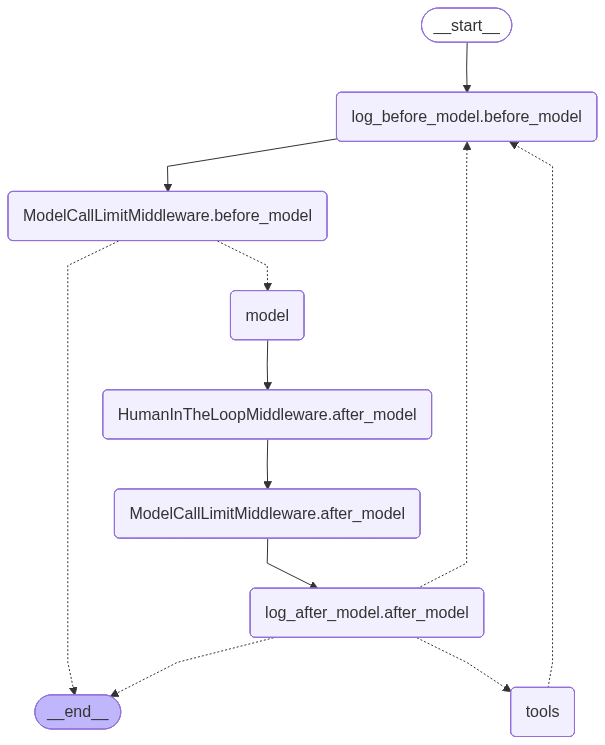

In [94]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

---
## ❓ Question #3:

How does **Agentic RAG** differ from traditional RAG? What are the advantages and potential disadvantages of letting the agent decide when to retrieve information?

##### ✅ Answer:
With Agentic RAG, especially with the more advanced LLMs allow you to write far less logic on how an Agent has to interact with data.  

In Traditional RAG retrieval is hard-coded into the flow:
User query -> Retrieve top-k documents -> Stuff into prompt -> LLM generates answer

The retrieval happens every time, regardless of whether it’s needed.  In personal work I've built a RAG application with TONS of data and was constantly pushing the overall LLM context limit by trying to inject an entire company financial history into the prompt.  A major disadvantage here of Traditional RAG is:
* LLM cost - all those tokens, may be un-used
* LLM speed - slower with all that contex (so much of it may not be needed)
* Inflexible - I had to pick what data was sent to the LLM, it limits the capabilities to answer certain questions because I can't actually give it ALL the context I need.
* Limited - Follow up questions, or multi-step reasoning arent really possible because if the question is outside of the initial data, I can't get more data into the LLM without another RAG call and then again, context is an issue..

The Advantage of Traditional RAG is its more deterministic..  The agent never 'forgets' to call the tool because the data is right there already stuffed into the prompt.  Overall Traditional RAG is strong with:
* Predictable behavior
* No risk of “forgot to call the tool to retrieve”
* Easier to control cost and latency
* Works well for fact-lookup and Q&A

The Advantage of Agentic Rag is that the agent can dynamically decide what tools it needs to call and when.  It can loop, get information, process it, and call more tools.

Advantages of Agentic RAG
* information retrieval only when needed
  * reduced latency
  * reduced token usage
* possible multi-step and iterative retrieval
  * the agent can call multiple tools to get data OR take action in multiple steps
* Better reasoning over retrieved info
  * the agent can summarize
  * compare sources
  * check inconsistencies
  * retrieve again if confidence is low
* Natural fit for tool-rich agents
  * it composes cleanly with calculators, APIs, DBs
  * the agent can choose which tool is best for each subtask

Disadvantages of Agentic RAG
* Agent fails to call the tool or retrieve data when it should
  * could hallucinate from its own stale data (ask it what the date today is and sometimes.. no idea)
* Opaque - harder to reason about and debug
  * if a tool wasnt called, theres no trace as of why..
  * heres where you need LOTS of debugging and tracing 
* Its has a less predictable cost and latency profile
  * it has more power, so it can call lots of tools, enter guardrails
* If your prompts or tool names arent good.. then it will get the wrong answer possibly
* Evals are harder
  * retrieval and reasoning are now tangled together
  * hard to tell if its the model calling the wrong tool, or the system itself





## ❓ Question #4:

Looking at the middleware examples (`log_before_model`, `log_after_model`, and `ModelCallLimitMiddleware`), describe a real-world scenario where middleware would be essential for a production agent. What specific middleware hooks would you use and why?

##### ✅ Answer:
I'm working with someone who is building a support agent that can call tools (ticketing, billing lookup, refunds, respond to trouble tickets).  The company is in Germany so GDPR is a thing too.
Here we would use hooks to:
* runaway loops - don't let the model loop and continue to update the end-user trouble ticket with too many responses.  Don't let it continue to loop calling tools
* silent failures / missing observability - we need to know that every ticket has had a response
* tool loops hammering our own internal apis AND posssibly causing rate limits with external APIs (Zendesk, Amazon...)
* GDPR specific compliance issues (PII showing up in logs or being propertly forgotten/not stored depending on user email)





---
## 🏗️ Activity #2: Enhance the Agentic RAG System

Now it's your turn! Enhance the wellness agent by implementing ONE of the following:

### Option A: Add a New Tool
Create a new tool that the agent can use. Ideas:
- A tool that calculates BMI given height and weight
- A tool that estimates daily calorie needs
- A tool that creates a simple workout plan

### Option B: Create Custom Middleware
Build middleware that adds new functionality:
- Middleware that tracks which tools are used most frequently
- Middleware that adds a friendly greeting to responses
- Middleware that enforces a response length limit

### Option C: Improve the RAG Tool
Enhance the retrieval tool:
- Add metadata filtering
- Implement reranking of results
- Add source citations with relevance scores

In [ ]:
### YOUR CODE HERE ###

# Implement your enhancement below


In [ ]:
# Test your enhanced agent here
